# Importing Packages

In [1]:
from sklearn.datasets import load_files 
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


from tqdm.notebook import tqdm
from collections import  Counter
import statistics as st
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split, ShuffleSplit, learning_curve, GridSearchCV   
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, f1_score
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package wordnet to /home/dkouts/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/dkouts/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /home/dkouts/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Downloading and preprocessing the data.

In [2]:
# Download the data
!wget http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz
!tar xvzf review_polarity.tar.gz

--2023-03-08 23:48:47--  http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3127238 (3.0M) [application/x-gzip]
Saving to: ‘review_polarity.tar.gz’

review_polarity.tar 100%[===================>]   2.98M   571KB/s    in 6.1s    

2023-03-08 23:48:53 (500 KB/s) - ‘review_polarity.tar.gz’ saved [3127238/3127238]

txt_sentoken/neg/cv000_29416.txt
txt_sentoken/neg/cv001_19502.txt
txt_sentoken/neg/cv002_17424.txt
txt_sentoken/neg/cv003_12683.txt
txt_sentoken/neg/cv004_12641.txt
txt_sentoken/neg/cv005_29357.txt
txt_sentoken/neg/cv006_17022.txt
txt_sentoken/neg/cv007_4992.txt
txt_sentoken/neg/cv008_29326.txt
txt_sentoken/neg/cv009_29417.txt
txt_sentoken/neg/cv010_29063.txt
txt_sentoken/neg/cv011_13044.txt
txt_sentoken/neg/cv012_29411.txt
txt_sentoken/neg/cv01

In [3]:
# load the datafiles  
movies = load_files(container_path="txt_sentoken", encoding="utf-8")  
x, y = movies.data, movies.target

In [4]:
# Preprocessing of the data
lemmatizer = WordNetLemmatizer()
docs = []

for doc in tqdm(x):
    # Remove non-word (special) characters such as punctuation etc
    document = re.sub(r'\W', ' ', str(doc))

    # Remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
      
    # Substitute multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)

    # Convert to Lowercase
    document = document.lower()

    # Split the document based on whitespaces (--> List of words)
    document = document.split()
    
    # Lemmatization
    document = [lemmatizer.lemmatize(word) for word in document]
    
    # Reconstruct the document by joining the words on each whitespace
    document = ' '.join(document)

    # Append all documents into a list 'docs'
    docs.append(document)

  0%|          | 0/2000 [00:00<?, ?it/s]

# Exploratory Data Analysis

In [5]:
docs_len=[] #storing the length of each text
for i in range(len(docs)):
   x=len(docs[i])
   docs_len.append(x)
print('The average document length is:',int(st.mean(docs_len)),'(characters).') #computing the average document length
print('The standard deviation of document legth is:',int(st.stdev(docs_len)),'(characters).') #computing the standard deviation of document length
print('The minimum document legth is:',int(min(docs_len)),'(characters).')
print('The maximum document legth is:',int(max(docs_len)),'(characters).')

The average document length is: 3528 (characters).
The standard deviation of document legth is: 1559 (characters).
The minimum document legth is: 84 (characters).
The maximum document legth is: 13745 (characters).


In [6]:
df=pd.DataFrame(docs,columns=['Document']) 
df.describe()

,Document
count,2000
unique,1998
top,the tagline for this film is some house are ju...
freq,2


In [7]:
df=df.drop_duplicates() # dropping duplicates

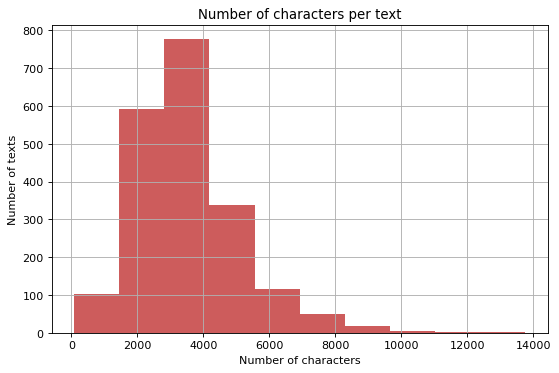

In [8]:
plt.figure(figsize=(8, 5), dpi=80)
ax=df['Document'].str.len().hist(color='indianred')
plt.xlabel('Number of characters')
plt.ylabel('Number of texts')
plt.title('Number of characters per text')
plt.savefig('EDA_1.png')

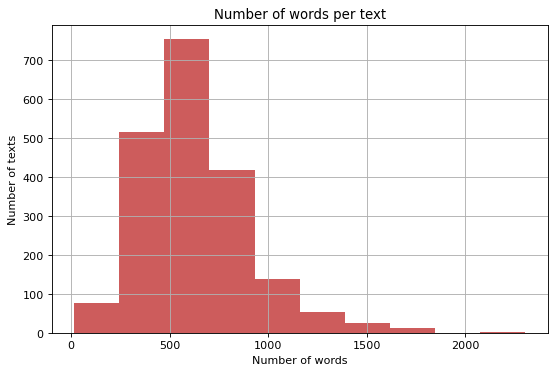

In [9]:
plt.figure(figsize=(8, 5), dpi=80)
ax=df['Document'].str.split().map(lambda x: len(x)).hist(color='indianred')
plt.xlabel('Number of words')
plt.ylabel('Number of texts')
plt.title('Number of words per text')
plt.savefig('EDA_2.png')

In [10]:
# source: https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:100]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x) 

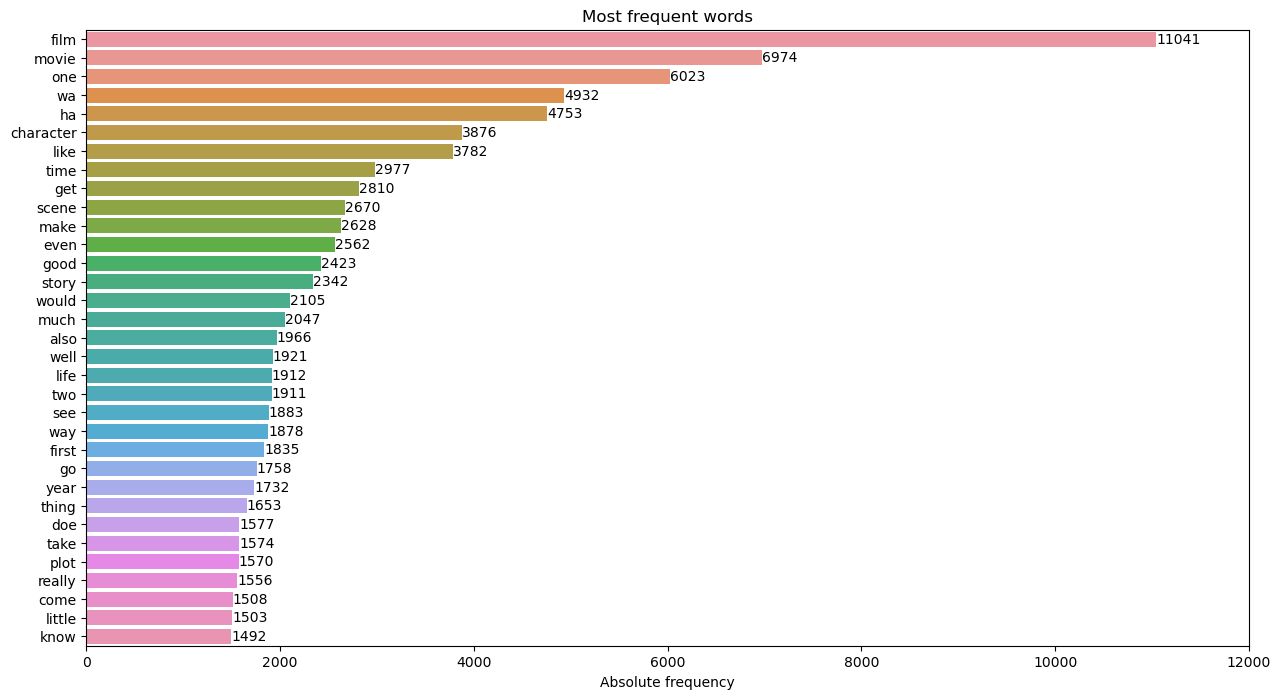

In [11]:
fig,ax = plt.subplots(figsize=(15,8))
plot_top_non_stopwords_barchart(df['Document'])
_ = ax.set_title('Most frequent words')
_ = ax.set_xlabel('Absolute frequency')
_ = ax.set_xlim(0,12000)
ax.bar_label(ax.containers[0])
plt.box('False')
plt.savefig('EDA_3.png')

# Model Training and Testing

In [12]:
# Split the dataset into train and test
x_train, x_test, y_train, y_test = train_test_split(docs, y, test_size=0.15, 
                                                    random_state=17022018)
print('Training texts:', len(x_train))
print('Testing texts:', len(x_test))

Training texts: 1700
Testing texts: 300


## Hyperparameter Tuning

In [ ]:
def model_tester2(estimator,x_train,y_train,x_test,y_test):
  '''
  params: estimator: an already trained pipeline object
          x_train, y_train, x_test, y_test: the training and testing data 
  
  output: f1-scores on the training and testing data
          classification reports of the training and testing data
          confusion matrix of the testing data
  '''

  predictions = estimator.predict(x_train)     #making predictions using the pipeline object and the training data
  score = f1_score(y_train, predictions)       #calculating the f1-score of the training data

  print("Train f1-score: {:.2f}%".format(score*100))

  predictions_test = estimator.predict(x_test)    #making predictions using the pipeline object and the testing data
  score = f1_score(y_test, predictions_test)      #calculating the f1-score of the testing data

  print("Test f1-score: {:.2f}% \n".format(score*100))

  print("\nThe classification report on the Train data:")
  print(classification_report(y_train, predictions))

  print("\nThe Classification report on the Test data")
  print(classification_report(y_test, predictions_test))

  print("\nConfusion Matrix for test data:")
  fig, ax = plt.subplots(figsize=(12,8))
  sns.heatmap(confusion_matrix(y_test, predictions_test),annot=True, cmap='mako', fmt='.5g', ax=ax)

### Dummy Classifier

In [ ]:
#creating a pipeling to combine the tfidf vectorizer and the DummyClassifier and train them together

du_pipeline = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(sublinear_tf=True, 
                                         stop_words=stopwords.words('english'), 
                                         max_features=5000)),
    ('du', DummyClassifier(strategy='most_frequent'))
])

In [ ]:
#fitting the dummy model
du_pipeline.fit(x_train, y_train)

Pipeline(steps=[('tfidf_vectorizer',
                 TfidfVectorizer(max_features=5000,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 sublinear_tf=True)),
                ('du', DummyClassifier(strategy='most_frequent'))])

Train f1-score: 0.00%
Test f1-score: 0.00% 


The classification report on the Train data:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       851
           1       0.00      0.00      0.00       849

    accuracy                           0.50      1700
   macro avg       0.25      0.50      0.33      1700
weighted avg       0.25      0.50      0.33      1700


The Classification report on the Test data
              precision    recall  f1-score   support

           0       0.50      1.00      0.66       149
           1       0.00      0.00      0.00       151

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300


Confusion Matrix for test data:


/home/dkouts/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dkouts/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dkouts/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dkouts/anaconda3/lib/pyth

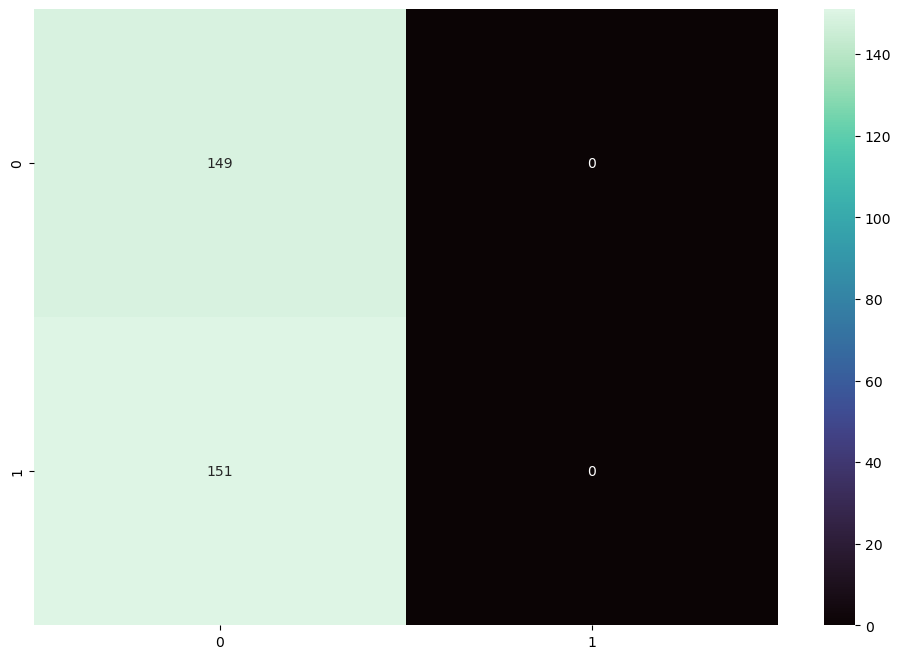

In [ ]:
model_tester2(du_pipeline, x_train, y_train, x_test, y_test)

### Logistic Regression

In [ ]:
#creating a pipeling to combine the tfidf vectorizer with the LogisticRegression Classifier and train them together

lr_pipeline = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(sublinear_tf=True,
                                         stop_words = stopwords.words('english'),
                                         max_features=5000)),
    ('lr', LogisticRegression())])

In [ ]:
#setting the parameters that GridSearch will go through to find the best combination
grid_params = {
    'lr__solver': ['lbfgs','liblinear','newton-cg','sag','saga'],
    'lr__C': [0.1,0.5,1.0],
    'lr__max_iter': [100, 500, 1000, 10000],
    'tfidf_vectorizer__ngram_range': [(1,1), (1,2), (1, 3)]
}

#performing the grid search
clf = GridSearchCV(lr_pipeline, grid_params, scoring = 'accuracy', cv = 5, verbose = 10, n_jobs=-1,refit=True)

#fitting the model that grid search found to be the best
clf.fit(x_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV 1/5; 1/180] START lr__C=0.1, lr__max_iter=100, lr__solver=lbfgs, tfidf_vectorizer__ngram_range=(1, 1)
[CV 2/5; 1/180] START lr__C=0.1, lr__max_iter=100, lr__solver=lbfgs, tfidf_vectorizer__ngram_range=(1, 1)
[CV 3/5; 1/180] START lr__C=0.1, lr__max_iter=100, lr__solver=lbfgs, tfidf_vectorizer__ngram_range=(1, 1)
[CV 5/5; 1/180] START lr__C=0.1, lr__max_iter=100, lr__solver=lbfgs, tfidf_vectorizer__ngram_range=(1, 1)
[CV 4/5; 1/180] START lr__C=0.1, lr__max_iter=100, lr__solver=lbfgs, tfidf_vectorizer__ngram_range=(1, 1)
[CV 1/5; 2/180] START lr__C=0.1, lr__max_iter=100, lr__solver=lbfgs, tfidf_vectorizer__ngram_range=(1, 2)
[CV 2/5; 2/180] START lr__C=0.1, lr__max_iter=100, lr__solver=lbfgs, tfidf_vectorizer__ngram_range=(1, 2)
[CV 3/5; 2/180] START lr__C=0.1, lr__max_iter=100, lr__solver=lbfgs, tfidf_vectorizer__ngram_range=(1, 2)
[CV 1/5; 3/180] START lr__C=0.1, lr__max_iter=100, lr__solver=lbfgs, tfidf_vectorizer__ng

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf_vectorizer',
                                        TfidfVectorizer(max_features=5000,
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    

In [ ]:
#the parameters that grid search found to be the best combination for the classification
clf.best_params_

{'lr__C': 1.0,
 'lr__max_iter': 100,
 'lr__solver': 'saga',
 'tfidf_vectorizer__ngram_range': (1, 1)}

In [ ]:
#setting the parameters of the previous pipeline to be the best parameters
lr_pipeline.set_params(**clf.best_params_)

Pipeline(steps=[('tfidf_vectorizer',
                 TfidfVectorizer(max_features=5000,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 sublinear_tf=True)),
                ('lr', LogisticRegression(solver='saga'))])

In [ ]:
#training the pipeline
lr_pipeline.fit(x_train,y_train)

Pipeline(steps=[('tfidf_vectorizer',
                 TfidfVectorizer(max_features=5000,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 sublinear_tf=True)),
                ('lr', LogisticRegression(solver='saga'))])

Train f1-score: 97.46%
Test f1-score: 83.55% 


The classification report on the Train data:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       851
           1       0.98      0.97      0.97       849

    accuracy                           0.97      1700
   macro avg       0.97      0.97      0.97      1700
weighted avg       0.97      0.97      0.97      1700


The Classification report on the Test data
              precision    recall  f1-score   support

           0       0.84      0.83      0.83       149
           1       0.83      0.84      0.84       151

    accuracy                           0.83       300
   macro avg       0.83      0.83      0.83       300
weighted avg       0.83      0.83      0.83       300


Confusion Matrix for test data:


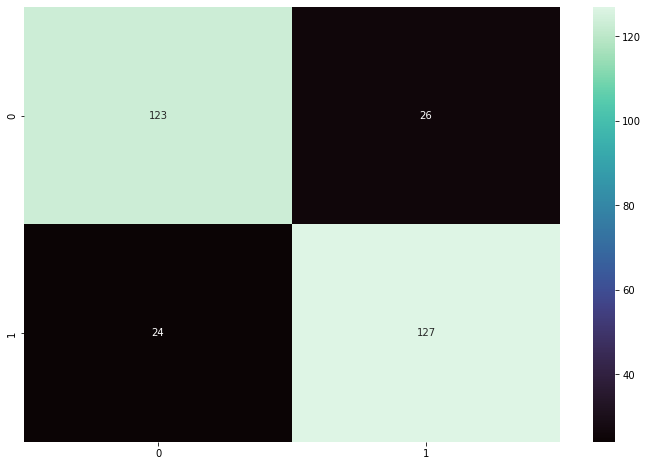

In [ ]:
model_tester2(lr_pipeline,x_train,y_train,x_test,y_test)

### SVM

In [ ]:
#creating a pipeling to combine the tfidf vectorizer with the SVM Classifier and train them together
svm_pipeline = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(sublinear_tf=True,
                                         stop_words = stopwords.words('english'),
                                         max_features=5000)),
    ('svm', SVC())])

In [ ]:
#setting the parameters that GridSearch will go through to find the best combination
grid_params = {
    'svm__C': [0.001, 0.01, 0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'tfidf_vectorizer__ngram_range': [(1,1), (1,2), (1, 3)]
}

In [ ]:
#performing the grid search
clf = GridSearchCV(svm_pipeline, grid_params, scoring = 'accuracy', cv = 5, verbose = 10, n_jobs=-1,refit=True)

#fitting the model that grid search found to be the best
clf.fit(x_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5; 1/60] START svm__C=0.001, svm__kernel=linear, tfidf_vectorizer__ngram_range=(1, 1)
[CV 2/5; 1/60] START svm__C=0.001, svm__kernel=linear, tfidf_vectorizer__ngram_range=(1, 1)
[CV 3/5; 1/60] START svm__C=0.001, svm__kernel=linear, tfidf_vectorizer__ngram_range=(1, 1)
[CV 4/5; 1/60] START svm__C=0.001, svm__kernel=linear, tfidf_vectorizer__ngram_range=(1, 1)
[CV 5/5; 1/60] START svm__C=0.001, svm__kernel=linear, tfidf_vectorizer__ngram_range=(1, 1)
[CV 1/5; 2/60] START svm__C=0.001, svm__kernel=linear, tfidf_vectorizer__ngram_range=(1, 2)
[CV 2/5; 2/60] START svm__C=0.001, svm__kernel=linear, tfidf_vectorizer__ngram_range=(1, 2)
[CV 3/5; 2/60] START svm__C=0.001, svm__kernel=linear, tfidf_vectorizer__ngram_range=(1, 2)
[CV 4/5; 2/60] START svm__C=0.001, svm__kernel=linear, tfidf_vectorizer__ngram_range=(1, 2)
[CV 5/5; 2/60] START svm__C=0.001, svm__kernel=linear, tfidf_vectorizer__ngram_range=(1, 2)
[CV 1/5; 3/60] STA

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf_vectorizer',
                                        TfidfVectorizer(max_features=5000,
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    

In [ ]:
#the parameters that grid search found to be the best combination for the classification
clf.best_params_

{'svm__C': 1, 'svm__kernel': 'rbf', 'tfidf_vectorizer__ngram_range': (1, 1)}

In [ ]:
#setting the parameters of the previous pipeline to be the best parameters
svm_pipeline.set_params(**clf.best_params_)

#training the pipeline
svm_pipeline.fit(x_train,y_train)

Pipeline(steps=[('tfidf_vectorizer',
                 TfidfVectorizer(max_features=5000,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 sublinear_tf=True)),
                ('svm', SVC(C=1))])

Train f1-score: 99.94%
Test f1-score: 84.21% 


The classification report on the Train data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       851
           1       1.00      1.00      1.00       849

    accuracy                           1.00      1700
   macro avg       1.00      1.00      1.00      1700
weighted avg       1.00      1.00      1.00      1700


The Classification report on the Test data
              precision    recall  f1-score   support

           0       0.84      0.83      0.84       149
           1       0.84      0.85      0.84       151

    accuracy                           0.84       300
   macro avg       0.84      0.84      0.84       300
weighted avg       0.84      0.84      0.84       300


Confusion Matrix for test data:


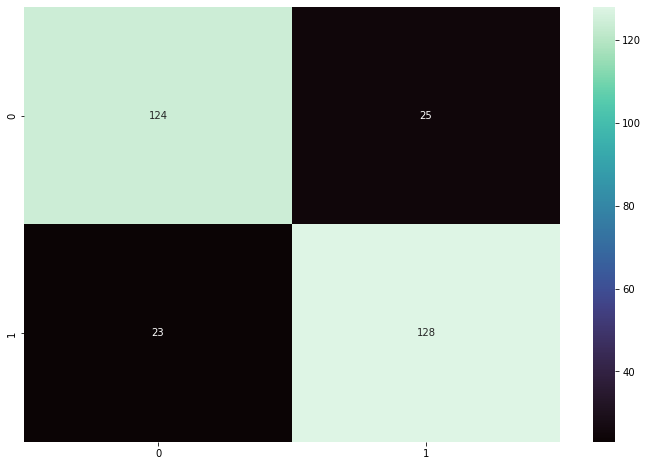

In [ ]:
model_tester2(svm_pipeline,x_train,y_train,x_test,y_test)

### K-NN

In [ ]:
#creating a pipeling to combine the tfidf vectorizer with the K-NN Classifier and train them together
knn_pipeline = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(sublinear_tf=True,
                                         stop_words = stopwords.words('english'),
                                         max_features=5000)),
    ('knn', KNeighborsClassifier(n_jobs=-1))])

In [ ]:
#setting the parameters that GridSearch will go through to find the best combination
grid_params = {
    'knn__n_neighbors': range(1,40),
    'tfidf_vectorizer__ngram_range': [(1,1), (1,2), (1, 3)]
}

In [ ]:
#performing the grid search
clf = GridSearchCV(knn_pipeline, grid_params, scoring = 'accuracy', cv = 5, verbose = 10, n_jobs=-1,refit=True)

#fitting the model that grid search found to be the best
clf.fit(x_train, y_train)

Fitting 5 folds for each of 117 candidates, totalling 585 fits
[CV 1/5; 1/117] START knn__n_neighbors=1, tfidf_vectorizer__ngram_range=(1, 1)..
[CV 2/5; 1/117] START knn__n_neighbors=1, tfidf_vectorizer__ngram_range=(1, 1)..
[CV 3/5; 1/117] START knn__n_neighbors=1, tfidf_vectorizer__ngram_range=(1, 1)..
[CV 4/5; 1/117] START knn__n_neighbors=1, tfidf_vectorizer__ngram_range=(1, 1)..
[CV 5/5; 1/117] START knn__n_neighbors=1, tfidf_vectorizer__ngram_range=(1, 1)..
[CV 1/5; 2/117] START knn__n_neighbors=1, tfidf_vectorizer__ngram_range=(1, 2)..
[CV 2/5; 2/117] START knn__n_neighbors=1, tfidf_vectorizer__ngram_range=(1, 2)..
[CV 3/5; 2/117] START knn__n_neighbors=1, tfidf_vectorizer__ngram_range=(1, 2)..
[CV 4/5; 2/117] START knn__n_neighbors=1, tfidf_vectorizer__ngram_range=(1, 2)..
[CV 5/5; 2/117] START knn__n_neighbors=1, tfidf_vectorizer__ngram_range=(1, 2)..
[CV 1/5; 3/117] START knn__n_neighbors=1, tfidf_vectorizer__ngram_range=(1, 3)..
[CV 2/5; 3/117] START knn__n_neighbors=1, tfid

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf_vectorizer',
                                        TfidfVectorizer(max_features=5000,
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    

In [ ]:
#the parameters that grid search found to be the best combination for the classification
clf.best_params_

{'knn__n_neighbors': 36, 'tfidf_vectorizer__ngram_range': (1, 1)}

In [ ]:
#setting the parameters of the previous pipeline to be the best parameters
knn_pipeline.set_params(**clf.best_params_)

#training the pipeline
knn_pipeline.fit(x_train,y_train)

Pipeline(steps=[('tfidf_vectorizer',
                 TfidfVectorizer(max_features=5000,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 sublinear_tf=True)),
                ('knn', KNeighborsClassifier(n_jobs=-1, n_neighbors=36))])

Train f1-score: 81.87%
Test f1-score: 77.71% 


The classification report on the Train data:
              precision    recall  f1-score   support

           0       0.85      0.75      0.80       851
           1       0.78      0.86      0.82       849

    accuracy                           0.81      1700
   macro avg       0.81      0.81      0.81      1700
weighted avg       0.81      0.81      0.81      1700


The Classification report on the Test data
              precision    recall  f1-score   support

           0       0.82      0.65      0.72       149
           1       0.71      0.85      0.78       151

    accuracy                           0.75       300
   macro avg       0.76      0.75      0.75       300
weighted avg       0.76      0.75      0.75       300


Confusion Matrix for test data:


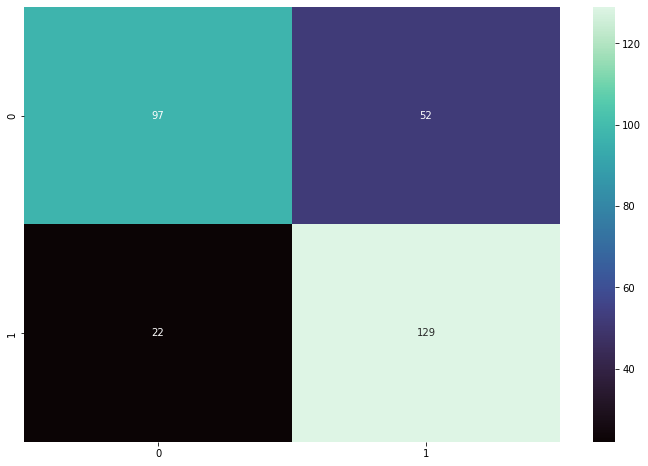

In [ ]:
model_tester2(knn_pipeline,x_train,y_train,x_test,y_test)

### MLP

In [ ]:
#creating a pipeling to combine the tfidf vectorizer with the MLP Classifier and train them together
mlp_pipeline = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(sublinear_tf=True,
                                         stop_words = stopwords.words('english'),
                                         max_features=5000)),
    ('mlp', MLPClassifier(early_stopping=True))])

In [ ]:
#setting the parameters that GridSearch will go through to find the best combination
grid_params = {
    'mlp__activation': ['logistic', 'relu', 'tanh'],
    'mlp__solver': ['lbfgs', 'adam', 'sgd'],
    'mlp__learning_rate': ['adaptive', 'constant'],
    'tfidf_vectorizer__ngram_range': [(1,1), (1,2), (1, 3)]
}

In [ ]:
#performing the grid search
clf = GridSearchCV(mlp_pipeline, grid_params, scoring = 'accuracy', cv = 5, verbose = 10, n_jobs=-1,refit=True)

#fitting the model that grid search found to be the best
clf.fit(x_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5; 1/54] START mlp__activation=logistic, mlp__learning_rate=adaptive, mlp__solver=lbfgs, tfidf_vectorizer__ngram_range=(1, 1)
[CV 2/5; 1/54] START mlp__activation=logistic, mlp__learning_rate=adaptive, mlp__solver=lbfgs, tfidf_vectorizer__ngram_range=(1, 1)
[CV 3/5; 1/54] START mlp__activation=logistic, mlp__learning_rate=adaptive, mlp__solver=lbfgs, tfidf_vectorizer__ngram_range=(1, 1)
[CV 4/5; 1/54] START mlp__activation=logistic, mlp__learning_rate=adaptive, mlp__solver=lbfgs, tfidf_vectorizer__ngram_range=(1, 1)
[CV 5/5; 1/54] START mlp__activation=logistic, mlp__learning_rate=adaptive, mlp__solver=lbfgs, tfidf_vectorizer__ngram_range=(1, 1)
[CV 1/5; 2/54] START mlp__activation=logistic, mlp__learning_rate=adaptive, mlp__solver=lbfgs, tfidf_vectorizer__ngram_range=(1, 2)
[CV 2/5; 2/54] START mlp__activation=logistic, mlp__learning_rate=adaptive, mlp__solver=lbfgs, tfidf_vectorizer__ngram_range=(1, 2)
[CV 3/5; 2/54]

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf_vectorizer',
                                        TfidfVectorizer(max_features=5000,
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    

In [ ]:
#the parameters that grid search found to be the best combination for the classification
clf.best_params_

{'mlp__activation': 'relu',
 'mlp__learning_rate': 'constant',
 'mlp__solver': 'lbfgs',
 'tfidf_vectorizer__ngram_range': (1, 2)}

In [ ]:
#setting the parameters of the previous pipeline to be the best parameters
mlp_pipeline.set_params(**clf.best_params_)

#training the pipeline
mlp_pipeline.fit(x_train,y_train)

Pipeline(steps=[('tfidf_vectorizer',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 sublinear_tf=True)),
                ('mlp', MLPClassifier(early_stopping=True, solver='lbfgs'))])

Train f1-score: 100.00%
Test f1-score: 84.69% 


The classification report on the Train data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       851
           1       1.00      1.00      1.00       849

    accuracy                           1.00      1700
   macro avg       1.00      1.00      1.00      1700
weighted avg       1.00      1.00      1.00      1700


The Classification report on the Test data
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       149
           1       0.83      0.86      0.85       151

    accuracy                           0.84       300
   macro avg       0.84      0.84      0.84       300
weighted avg       0.84      0.84      0.84       300


Confusion Matrix for test data:


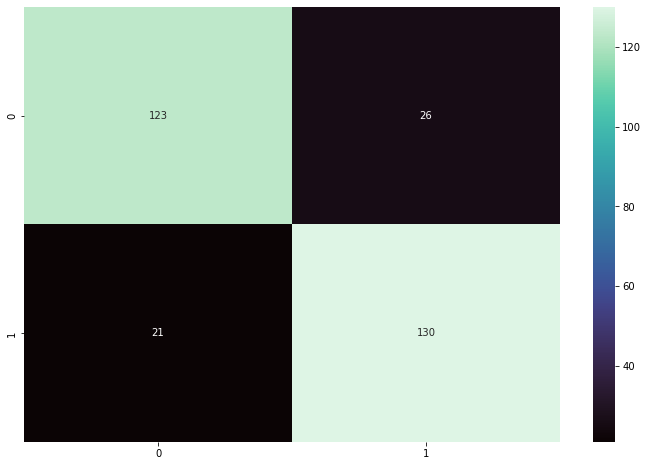

In [ ]:
model_tester2(mlp_pipeline,x_train,y_train,x_test,y_test)

### Naive Bayes

In [ ]:
#creating a pipeling to combine the tfidf vectorizer with the Naive Bayes Classifier and train them together
nb_pipeline = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(sublinear_tf=True,
                                         stop_words = stopwords.words('english'),
                                         max_features=5000)),
    ('nb', MultinomialNB())])

In [ ]:
#setting the parameters that GridSearch will go through to find the best combination
grid_params = {
    'tfidf_vectorizer__ngram_range': [(1,1), (1,2), (1, 3)]
}

In [ ]:
#performing the grid search
clf = GridSearchCV(nb_pipeline, grid_params, scoring = 'accuracy', cv = 5, verbose = 10, n_jobs=-1,refit=True)

#fitting the model that grid search found to be the best
clf.fit(x_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START tfidf_vectorizer__ngram_range=(1, 1)........................
[CV 2/5; 1/3] START tfidf_vectorizer__ngram_range=(1, 1)........................
[CV 3/5; 1/3] START tfidf_vectorizer__ngram_range=(1, 1)........................
[CV 4/5; 1/3] START tfidf_vectorizer__ngram_range=(1, 1)........................
[CV 5/5; 1/3] START tfidf_vectorizer__ngram_range=(1, 1)........................
[CV 1/5; 2/3] START tfidf_vectorizer__ngram_range=(1, 2)........................
[CV 2/5; 2/3] START tfidf_vectorizer__ngram_range=(1, 2)........................
[CV 3/5; 2/3] START tfidf_vectorizer__ngram_range=(1, 2)........................
[CV 4/5; 2/3] START tfidf_vectorizer__ngram_range=(1, 2)........................
[CV 5/5; 2/3] START tfidf_vectorizer__ngram_range=(1, 2)........................
[CV 1/5; 3/3] START tfidf_vectorizer__ngram_range=(1, 3)........................
[CV 2/5; 3/3] START tfidf_vectorizer__ngram_range

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf_vectorizer',
                                        TfidfVectorizer(max_features=5000,
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    

In [ ]:
#the parameters that grid search found to be the best combination for the classification
clf.best_params_

{'tfidf_vectorizer__ngram_range': (1, 1)}

In [ ]:
#setting the parameters of the previous pipeline to be the best parameters
nb_pipeline.set_params(**clf.best_params_)

#training the pipeline
nb_pipeline.fit(x_train,y_train)

Pipeline(steps=[('tfidf_vectorizer',
                 TfidfVectorizer(max_features=5000,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 sublinear_tf=True)),
                ('nb', MultinomialNB())])

Train f1-score: 92.74%
Test f1-score: 78.35% 


The classification report on the Train data:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       851
           1       0.94      0.91      0.93       849

    accuracy                           0.93      1700
   macro avg       0.93      0.93      0.93      1700
weighted avg       0.93      0.93      0.93      1700


The Classification report on the Test data
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       149
           1       0.81      0.75      0.78       151

    accuracy                           0.79       300
   macro avg       0.79      0.79      0.79       300
weighted avg       0.79      0.79      0.79       300


Confusion Matrix for test data:


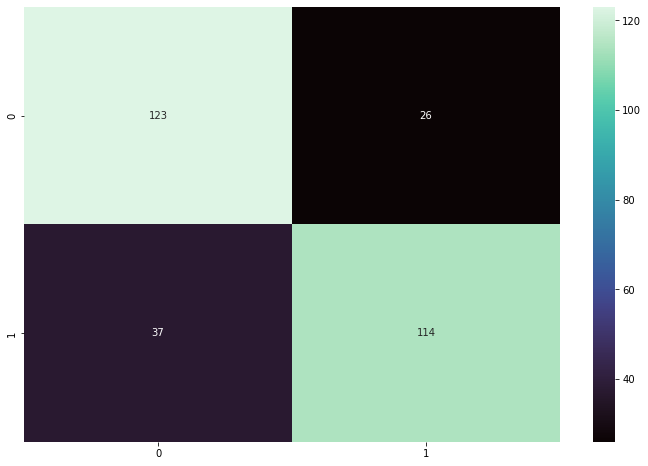

In [ ]:
model_tester2(nb_pipeline,x_train,y_train,x_test,y_test)

## Learning Curves

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
   
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("F1-score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs,scoring='f1', 
        train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, 
                     color="orange")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="orange",
             label="Cross-validation score")

    plt.legend(loc="lower right")
    return plt


#### Logistic Regression

/home/dimkouts/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/dimkouts/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/dimkouts/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


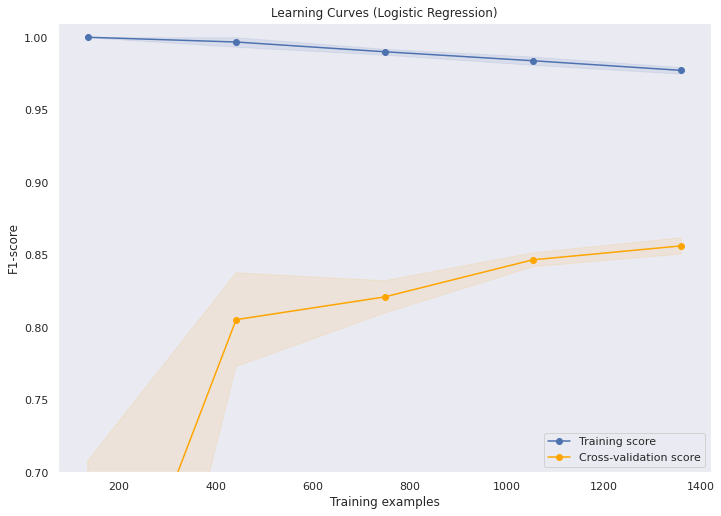

In [ ]:
title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
plot_learning_curve(lr_pipeline, title, x_train, y_train, 
                    ylim=(0.7, 1.01), cv=cv, n_jobs=-1)
plt.savefig('lr_lc.png')

### SVM

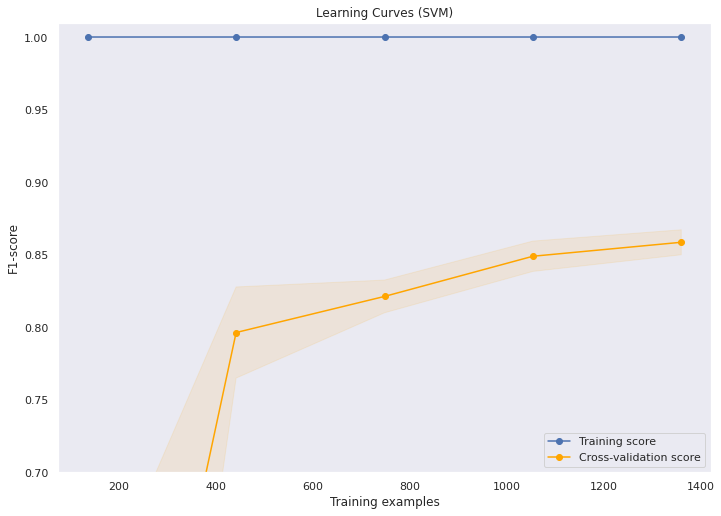

In [ ]:
title = "Learning Curves (SVM)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
plot_learning_curve(svm_pipeline, title, x_train, y_train, 
                    ylim=(0.7, 1.01), cv=cv, n_jobs=-1)
plt.savefig('svm_lc.png')

### K-NN

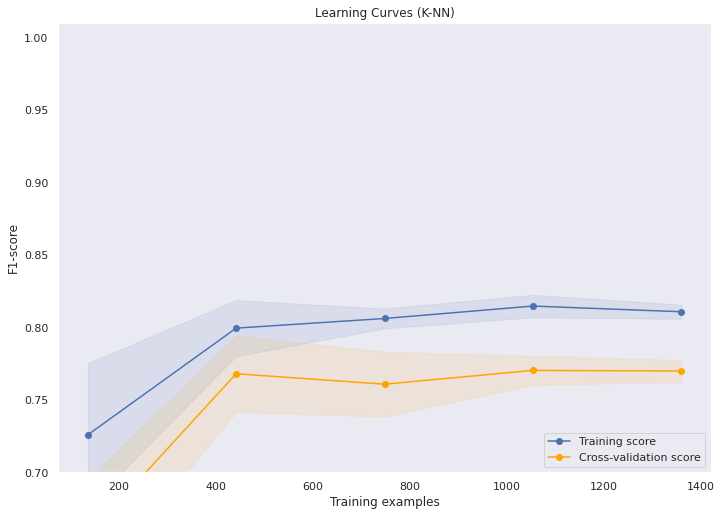

In [ ]:
title = "Learning Curves (K-NN)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
plot_learning_curve(knn_pipeline, title, x_train, y_train, 
                    ylim=(0.7, 1.01), cv=cv, n_jobs=-1)
plt.savefig('knn_lc.png')

### MLP

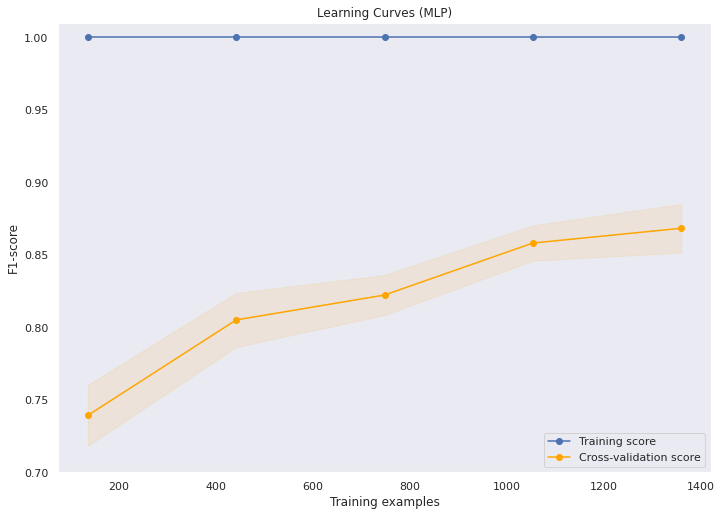

In [ ]:
title = "Learning Curves (MLP)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
plot_learning_curve(mlp_pipeline, title, x_train, y_train, 
                    ylim=(0.7, 1.01), cv=cv, n_jobs=-1)
plt.savefig('mlp_lc.png')

### Naive Bayes

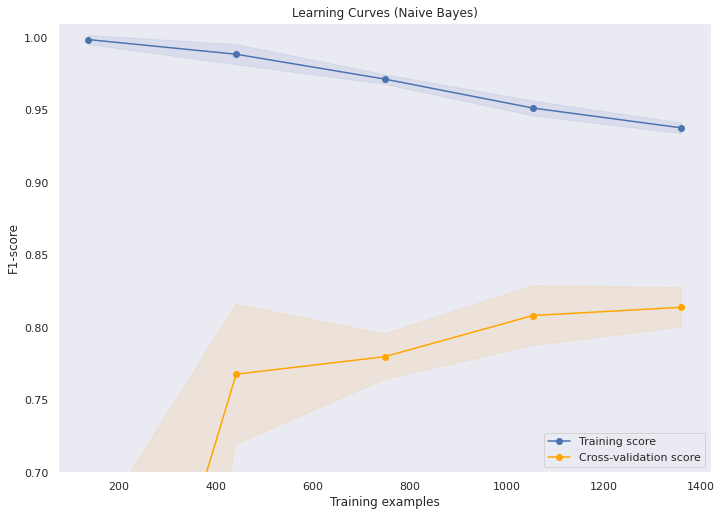

In [ ]:
title = "Learning Curves (Naive Bayes)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
plot_learning_curve(nb_pipeline, title, x_train, y_train, 
                    ylim=(0.7, 1.01), cv=cv, n_jobs=-1)
plt.savefig('nb_lc.png')

## PR-AUC

In [ ]:
#setting the parameter probability of the svm part of svm_pipeline to be True
svm_pipeline['svm'].set_params(probability = True)

SVC(C=1, probability=True)

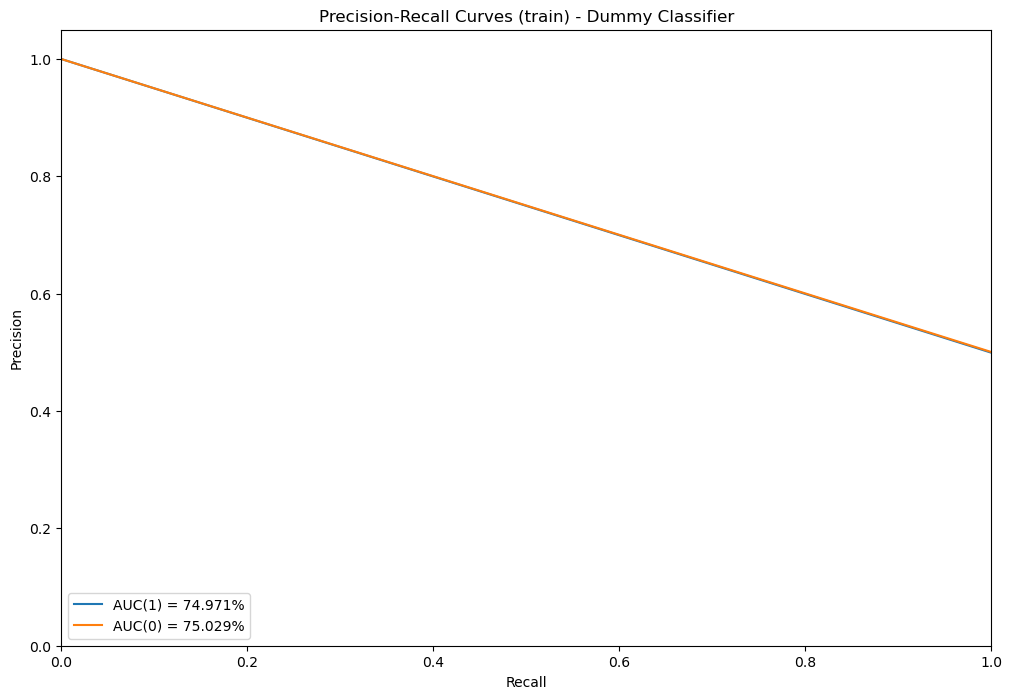

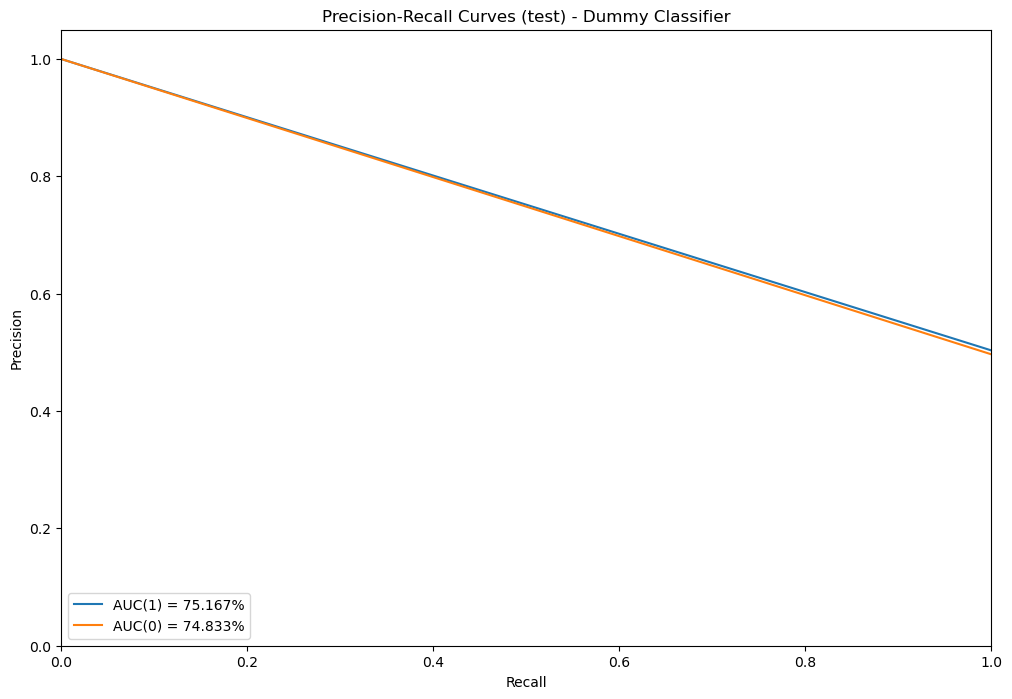

In [ ]:
pred_train = du_pipeline.predict_proba(x_train)
pred = du_pipeline.predict_proba(x_test)

precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, pred_train[:,1])
precision1_train, recall1_train, thresholds1_train = precision_recall_curve(y_train, pred_train[:,0], pos_label=0)
area_train = auc(recall_train, precision_train)
area1_train = auc(recall1_train, precision1_train)

plt.figure(figsize = (12,8))
plt.plot(recall_train, precision_train, label=f'AUC(1) = {area_train:.3%}')
plt.plot(recall1_train, precision1_train, label=f'AUC(0) = {area1_train:.3%}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curves (train) - Dummy Classifier')
plt.legend(loc="lower left")
plt.savefig('Dummy_AUC_train.png')

precision, recall, thresholds = precision_recall_curve(y_test, pred[:,1])
precision1, recall1, thresholds1 = precision_recall_curve(y_test, pred[:,0], pos_label=0)
area = auc(recall, precision)
area1 = auc(recall1, precision1)
plt.figure(figsize = (12,8))
plt.plot(recall, precision, label=f'AUC(1) = {area:.3%}')
plt.plot(recall1, precision1, label=f'AUC(0) = {area1:.3%}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curves (test) - Dummy Classifier')
plt.legend(loc="lower left")
plt.savefig('Dummy_AUC_test.png')

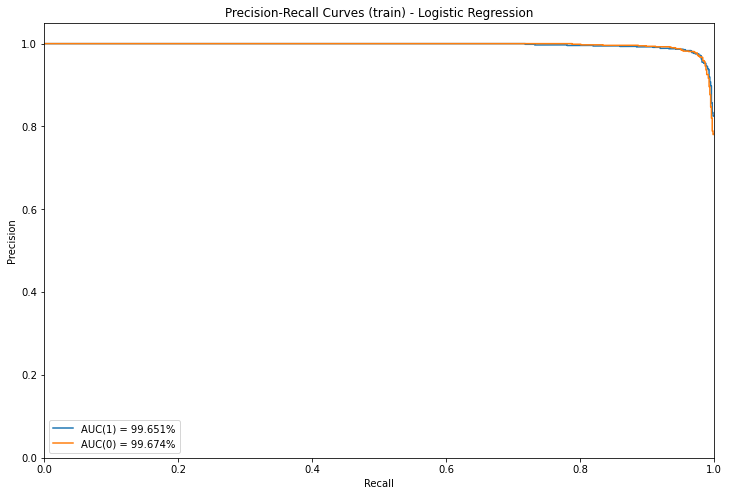

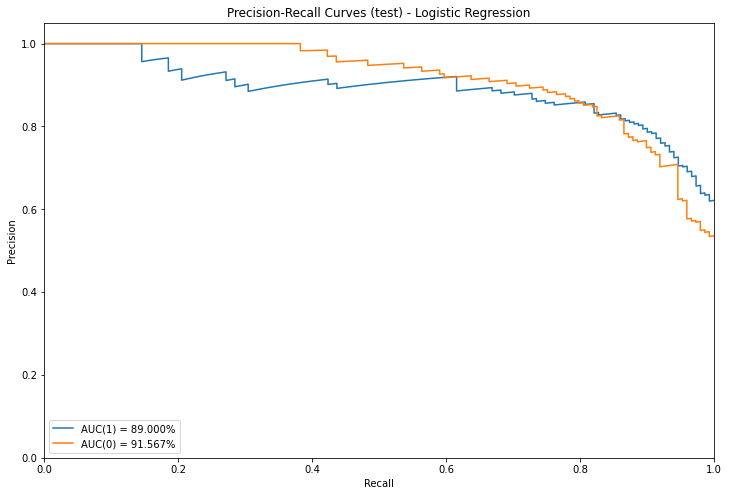

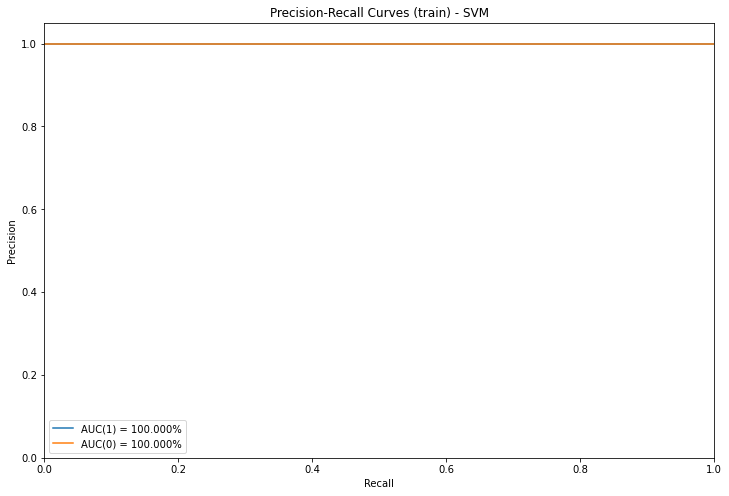

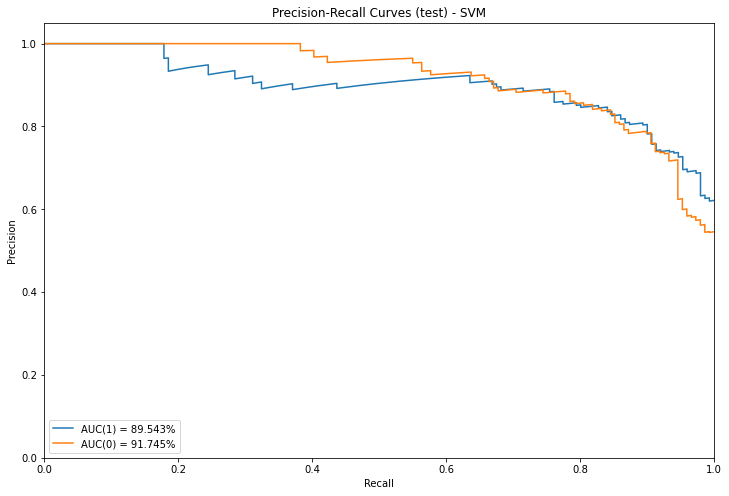

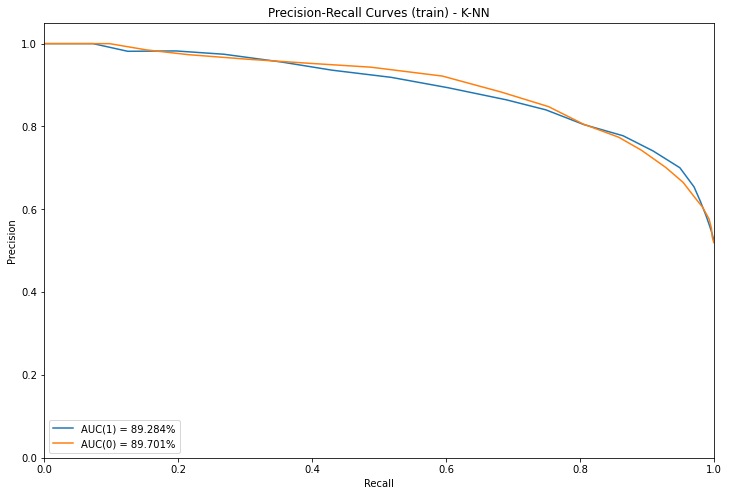

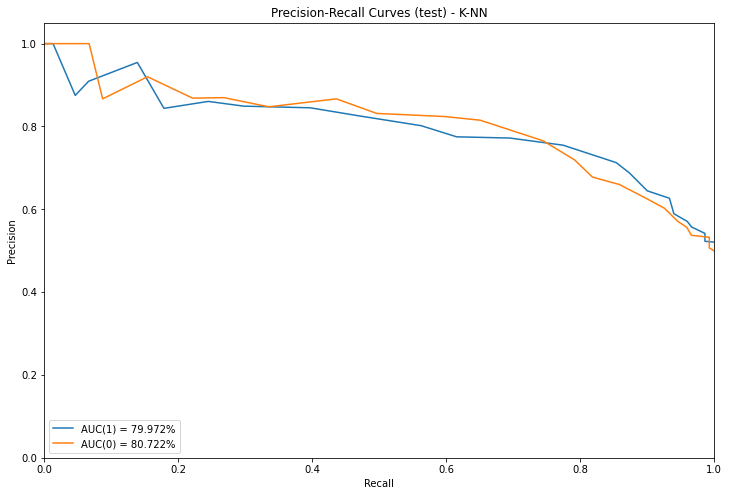

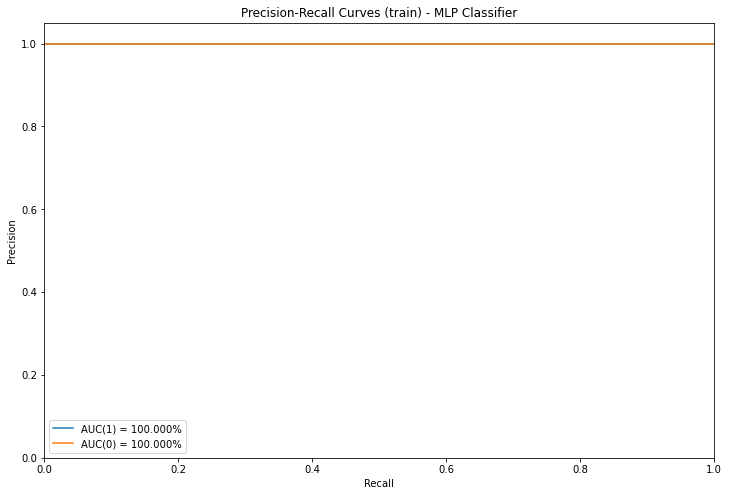

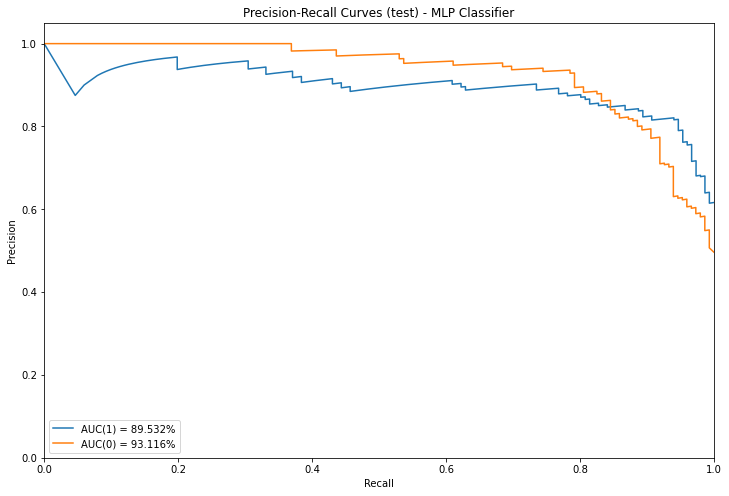

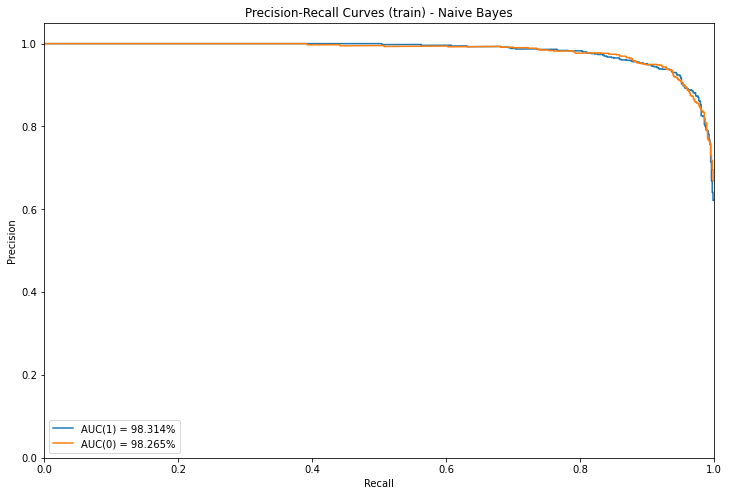

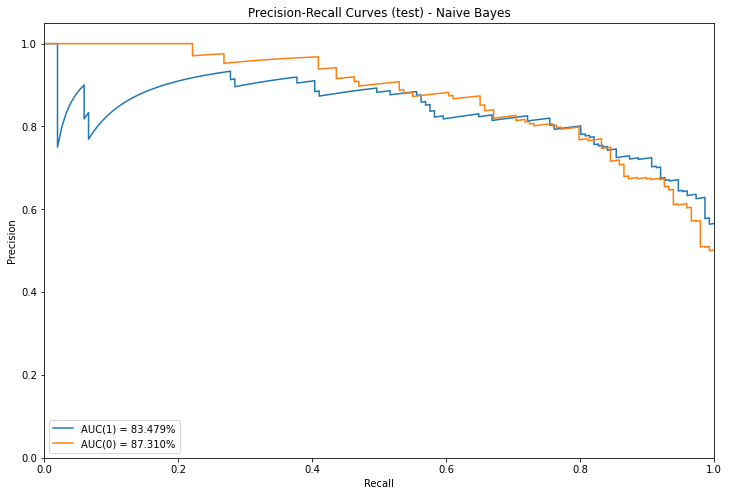

In [ ]:
np.seterr(all='ignore')

estimators = {'Logistic Regression':lr_pipeline,
              'SVM':svm_pipeline,
              'K-NN':knn_pipeline,
              'MLP Classifier':mlp_pipeline,
              'Naive Bayes':nb_pipeline}
        
for (name,estimator) in estimators.items():
    model = estimator
    model.fit(x_train, y_train)
    # We use the probabilities because the precision_recall_curve function needs them
    pred_train = model.predict_proba(x_train)
    pred = model.predict_proba(x_test)
    # model.predict() returns outputs of 0 or 1
    # model.predict_proba() returns an array: [P(x=0), P(x=1)]

    precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, pred_train[:,1])
    precision1_train, recall1_train, thresholds1_train = precision_recall_curve(y_train, pred_train[:,0], pos_label=0)
    area_train = auc(recall_train, precision_train)
    area1_train = auc(recall1_train, precision1_train)

    plt.figure(figsize = (12,8))
    plt.plot(recall_train, precision_train, label=f'AUC(1) = {area_train:.3%}')
    plt.plot(recall1_train, precision1_train, label=f'AUC(0) = {area1_train:.3%}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Precision-Recall Curves (train) - {name}')
    plt.legend(loc="lower left")
    plt.savefig(f'{name}_AUC_train.png')

    precision, recall, thresholds = precision_recall_curve(y_test, pred[:,1])
    precision1, recall1, thresholds1 = precision_recall_curve(y_test, pred[:,0], pos_label=0)
    area = auc(recall, precision)
    area1 = auc(recall1, precision1)
    plt.figure(figsize = (12,8))
    plt.plot(recall, precision, label=f'AUC(1) = {area:.3%}')
    plt.plot(recall1, precision1, label=f'AUC(0) = {area1:.3%}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Precision-Recall Curves (test) - {name}')
    plt.legend(loc="lower left")
    plt.savefig(f'{name}_AUC_test.png')